In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
from torch import nn
from skimage.io import imshow
%matplotlib inline
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
from IPython.core.debugger import set_trace

from interpolation import two_point_interpolation, n_point_interpolation, \
    vicinity_sampling, analogies, gaussian_interpolation

In [2]:
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2*dimZ))
        
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 6075 * 2)
        )
        self.s = nn.Sigmoid()
    def gaussian_sampler(self, mu, logsigma):
        #print(mu.size(), logsigma.size())
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        combined = self.encoder(x)
        return combined[:, :dimZ], combined[:, dimZ:]
        
    def decode(self, x):
        combined = self.decoder(x)
        return self.s(combined[:, :6075]), combined[:, 6075:]
        
    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        samples = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(samples)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma


In [3]:
def plot_torch_picture(tensor, ax=None):
    if ax is None:
        plt.imshow(tensor.detach().reshape((45,45, 3)))
        plt.axis('off')
        plt.show()
    else:
        ax.axis('off')
        ax.imshow(tensor.detach().reshape((45,45, 3)))

In [4]:
net_VAE = VAE().to('cpu')
net_VAE.load_state_dict(torch.load('VAE-deepfunneled/weights-vae-deepfunneled', map_location='cpu'))
net_VAE.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=12150, bias=True)
  )
  (s): Sigmoid()
)

In [5]:
X_val = np.load('X_val.npy')

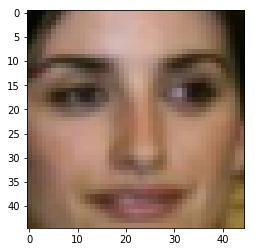

In [49]:
my_image = X_val[7].copy()

plt.imshow(my_image, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

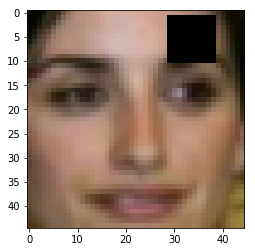

In [68]:
ind_1 = np.random.randint(0,my_image.shape[1])
ind_2 = np.random.randint(0,my_image.shape[1])

size = 10
IMG_cor_1 = my_image.copy()
IMG_cor_1[ind_1:ind_1 + size, ind_2: ind_2 + size][:, :, :] = 0
plt.imshow(IMG_cor_1, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

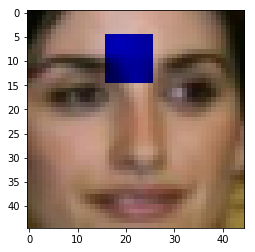

In [71]:
ind_1 = np.random.randint(0,my_image.shape[1])
ind_2 = np.random.randint(0,my_image.shape[1])

size = 10
IMG_cor_2 = my_image.copy()
IMG_cor_2[ind_1:ind_1 + size, ind_2: ind_2 + size][:, :, :2] = 0
plt.imshow(IMG_cor_2, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

In [72]:
IMG = my_image.copy()
IMG = np.float32(IMG)
IMG = IMG/ 255
IMG = IMG.reshape(1,-1)
tensor_norm = torch.Tensor(IMG)

IMG_cor_1 = np.float32(IMG_cor_1)
IMG_cor_1 = IMG_cor_1 / 255
IMG_cor_1 = IMG_cor_1.reshape(1,-1)
tensor_1 = torch.Tensor(IMG_cor_1)

IMG_cor_2 = np.float32(IMG_cor_2)
IMG_cor_2 = IMG_cor_2 / 255
IMG_cor_2 = IMG_cor_2.reshape(1,-1)
tensor_2 =torch.Tensor(IMG_cor_2)

In [73]:
latent_norm , _= net_VAE.encode(tensor_norm)
latent_1, _ = net_VAE.encode(tensor_1)
latent_2, _ = net_VAE.encode(tensor_2)
latent_1 = latent_1.detach()
latent_2 = latent_2.detach()

In [74]:
img_reconstructed, _ = net_VAE.decode(latent_norm)
img_rec_1, _ = net_VAE.decode(latent_1)
img_rec_2, _ = net_VAE.decode(latent_2)

In [75]:
def interpolation_sequence_generation(list_t, rand1, rand2):
    rand1 = rand1
    rand2 = rand2
    interpolation_ot =[]
    interpolation_no_scale = []
    for t in reversed(list_t):
        interpolation_ot.append(two_point_interpolation(rand1, rand2, t=t, do_scale=True))
        interpolation_no_scale.append(two_point_interpolation(rand1, rand2,t = t, do_scale=False))
    
    output1, _ = net_VAE.decode(rand1)
    output2, _ = net_VAE.decode(rand2)

    fig, axs = plt.subplots(nrows=2, ncols=len(list_t)+2, sharex=True,figsize = (20,5))
#     set_trace()
    plot_torch_picture(output1, ax = axs[0,0])
    plot_torch_picture(output2, ax = axs[0,len(list_t)+1])
    plot_torch_picture(output1, ax = axs[1,0])
    plot_torch_picture(output2, ax = axs[1,len(list_t)+1])
    for i in range(len(list_t)):
        plot_torch_picture(net_VAE.decode(interpolation_ot[i])[0], ax = axs[0,i+1])
        plot_torch_picture(net_VAE.decode(interpolation_no_scale[i])[0], ax = axs[1,i+1])
#         set_trace()
    pass

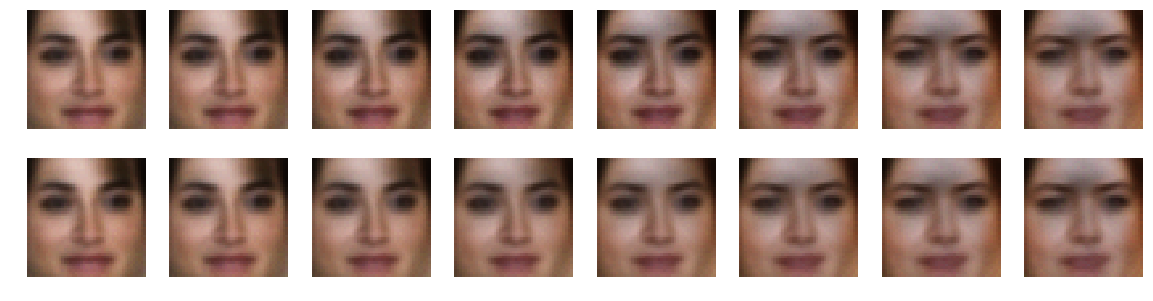

In [76]:
list_t = np.linspace(0.1, 0.9, 6)
interpolation_sequence_generation(list_t, latent_1, latent_2)

In [58]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())